In [1]:
%matplotlib inline

from imageio import imread
import numpy as np
from skimage import color, filters, img_as_float
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def get_tile(tile_row, tile_col, img, img_gray, img_binary):
    tile_h = int(img.shape[0]/5)
    tile_w = int(img.shape[1]/5)
    y0, y1, x0, x1 = tile_row*tile_h, ((tile_row+1)*tile_h), tile_col*tile_w, (tile_col+1)*tile_w
    tile = img[y0:y1, x0:x1, :]
    tile_gray = img_gray[y0:y1, x0:x1]
    tile_binary = img_binary[y0:y1, x0:x1]
    return tile, tile_gray, tile_binary

In [76]:
from scipy.misc import imresize
MAX_SIZE = 224


def im_normalized_read(fname, size_limit = MAX_SIZE):
    from skimage.transform import resize
    img =  imread(fname)
    max_len = np.max(img.shape)
    if max_len <= size_limit:
        return img_as_float(img)
    ratio = size_limit/max_len
    new_img = imresize(img, size=ratio, interp='bicubic')
    return img_as_float(new_img)

# Color Moments

In [5]:
def calc_moment3(arr, moment1):
    cubed = np.mean((arr-moment1)**3)
    return math.pow(abs(cubed),1/3) * (1,-1)[cubed<0]

In [6]:
def calc_moments(arr):
    moment1 = np.mean(arr)
    moment2 = np.mean((arr-moment1)**2)**(1/2)
    moment3 = calc_moment3(arr, moment1)
    return moment1, moment2, moment3

In [7]:
def calc_4_rgb_moments(rgbarr):
    r1, r2, r3 = calc_moments(rgbarr[:, :, 0])
    g1, g2, g3 = calc_moments(rgbarr[:, :, 1])
    b1, b2, b3 = calc_moments(rgbarr[:, :, 2])
    gray = color.rgb2gray(rgbarr)
    gr1, gr2, gr3 = calc_moments(gray)
    return [r1, r2, r3, g1, g2, g3, b1, b2, b3, gr1, gr2, gr3]

# DOOG filter


Based on "Preattentive texture discrimination with early vision mechanisms", Fig. 2.

In [8]:
def G(y0, sigmax, sigmay, x, y):
    # The definition of G seems wrong, I refer original Yang's paper.
    # return (1/(2*math.pi* sigmax*sigmay)) *np.exp(- (x**2) + (y- y0/sigmay)**2)
    dimx = len(x)
    dimy = len(y)
    return (1/(2*math.pi* sigmax*sigmay)) *np.exp(- (1/2) * (((x/sigmax)**2).reshape(1, dimx) + (((y- y0)/sigmay)**2).reshape(dimy, 1)))

In [9]:
def DOOG2(x, y, sigma, r=3):
    sigmay = sigma
    sigmax = r*sigma
    ya = sigma
    yc = -sigma
    return -G(ya, sigmax, sigmay, x, y) + 2*G(0, sigmax, sigmay, x, y) - G(yc, sigmax, sigmay, x, y)

In [10]:
def DOOG2_weight(sigma, r=3, truncate=4):
    # similar filter size logic as filters.gaussian of scipy.
    lw = int(truncate * sigma + 0.5)
    return DOOG2(np.arange(-lw, lw+1), np.arange(-lw, lw+1), sigma, r)

In [11]:
# https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.ndimage.filters.convolve.html
from scipy.ndimage.filters import convolve

In [12]:
def kernel2feature(img, weights):
    return np.mean([np.mean(convolve(img[:, :, i], weights)) for i in range(3)])

In [13]:
# use global variable for speed
# use sigma of 1, 2, 4, 8

KERNELS = [DOOG2_weight(i) for i in [1, 2, 4, 8]]

In [14]:
def tile2doog_features(tile):
    # to make scale similar
    return [1000*kernel2feature(tile, kernel) for kernel in KERNELS]

# Orientation Filter

In [15]:
from scipy.stats import norm

In [16]:
def DOG(y, sigma1=0.5, sigma2=1.5):
    fy1 = norm.pdf(y, scale=sigma1)
    fy2 = norm.pdf(y, scale=sigma2)
    dog = fy1 - fy2
    return dog

In [17]:
def calc_f1(x, y, sigma):
    fx = norm.pdf(x, scale=sigma).reshape(1, len(x))
    fy = DOG(y).reshape(len(y), 1)
    # should access f1[y][x]
    return fx*fy

In [18]:
from scipy.signal import hilbert

In [19]:
def calc_f1f2(x, y, sigma):
    f1 = calc_f1(x, y, sigma)
    f2 = np.imag(hilbert(f1))
    return f1, f2

In [20]:
def rotation_indices(theta, shape):
    """return ([y1, y2, y3, ...], [x1, x2, x3, ...]). Use for numpy indices"""
    y_lim, x_lim = shape
    cos = math.cos(theta)
    sin = math.sin(theta)
    pairs = [(min(y_lim-1, max(0, int(x*sin + y*cos))),
              min(x_lim-1, max(0, int(x*cos - y*sin))))
            for y in range(y_lim)
            for x in range(x_lim)]
    return list(zip(*pairs))
    

### calc weights

In [21]:
def orientation_weights(theta, sigma, truncate=4):
    # similar filter size logic as filters.gaussian of scipy.
    lw = int(truncate * sigma + 0.5)
    
    x = np.arange(-lw, lw+1)
    y = np.arange(-lw, lw+1)
    f1, f2 = calc_f1f2(x, y, sigma)
    inds = rotation_indices(theta, f1.shape)
    f1r = f1[inds].reshape(f1.shape)
    f2r = f2[inds].reshape(f2.shape)
    return f1r, f2r

In [22]:
def orientation_energy(img, theta, sigma=1.5, truncate=4):
    f1, f2 = orientation_weights(theta, sigma)
    ex2 = convolve(img, f1)**2
    ey2 = convolve(img, f2)**2
    # make scale similar
    return 1000*np.mean(ex2+ey2)

In [23]:
def orientation_12_energy(gray_img):
    return [orientation_energy(gray_img, i*(2*math.pi)/12) for i in range(12)]

# Shape features

In [24]:
from skimage.filters import threshold_otsu

In [25]:
def gray2binary(gray_img):
    threds = threshold_otsu(gray_img)
    return gray_img <= threds

In [26]:
import skimage

### perimeter, area

In [27]:
# Paper says the ratio of the area to the perimeter squared, but inverse is much more common, which is compactness.
# standard definition divide this value with 4pi, but it's not important for our case.

def compactness(img_binary):
    l = skimage.measure.perimeter(img_binary)
    area = img_binary.sum()
    if area == 0:
        return 1, area
    return (l**2)/area, area

### Moment of inertia

In [28]:
def calc_moment_of_inertia(gray_img):
    # cr, cc = ``M[1, 0] / M[0, 0]``, ``M[0, 1] / M[0, 0]`
    M1 = skimage.measure.moments(gray_img, order=1)
    cr = M1[1, 0]/M1[0, 0]
    cc = M1[0, 1]/M1[0, 0]
    mu2 = skimage.measure.moments_central(gray_img, cr, cc, order=2)
    # paper says shape feature is 4. So I use mu2_20 and mu2_02 as a separate features
    # return (mu2[2, 0]+mu2[0, 2])/mu2[0, 0]
    M0sq = mu2[0, 0]**2
    return mu2[2, 0]/M0sq, mu2[0, 2]/M0sq

In [29]:
from skimage.morphology import convex_hull_image
def ratio_convex_hull(img_bainary, area):
    hull_area = convex_hull_image(img_bainary).sum()
    return area/hull_area

### Combine all shape features

In [30]:
def shape_features(img_gray, img_binary):
    comp, area = compactness(img_binary)
    mom = calc_moment_of_inertia(img_gray)
    if(img_binary.any()):
        ratio3 = ratio_convex_hull(img_binary, area)
    else:
        ratio3 = 1
    return [comp, mom[0], mom[1], ratio3]

## Combine all features

In [31]:
def tile2features(tile, tile_gray, tile_binary):
    rgb_moments12 = calc_4_rgb_moments(tile)
    doog4 = tile2doog_features(tile)
    orientation12 = orientation_12_energy(tile_gray)
    shape4 = shape_features(tile_gray, tile_binary)
    return [elem for arr in [rgb_moments12, doog4, orientation12, shape4]
            for elem in arr]

# img2features

In [32]:
def get_tile_features(tile_row, tile_col, img, img_gray, img_binary):
    tile, tile_gray, tile_binary = get_tile(tile_row, tile_col, img, img_gray, img_binary)
    return tile2features(tile, tile_gray, tile_binary)

In [33]:
def img2features(img):
    img_gray = color.rgb2gray(img)
    img_binary = gray2binary(img_gray)
    featuresList = [get_tile_features(row, col, img, img_gray, img_binary) for row in range(5)
                    for col in range(5)]
    return [f for fs in featuresList
               for f in fs]

# Create features and save to dataframe

In [82]:
from models.modelutils import dir2filedict

Using TensorFlow backend.


In [83]:
fdict = dir2filedict("data")

In [84]:
files = sorted(f for fs in fdict.values() for f in fs)

In [85]:
len(files)

11815

In [86]:
sfiles = files[0:100]

### Below here is too slow.

In [ ]:
current = ""

In [45]:
def files2features(files):
    global current
    res = []
    for f in files:
        current = f
        res.append(img2features(img_as_float(imread(f))))
    return res

In [88]:
%%time
flist = list(map(lambda file: img2features(im_normalized_read(file)), sfiles[0:2]))
# flist = files2features(sfiles)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if sys.path[0] == '':


CPU times: user 19.2 s, sys: 2.39 s, total: 21.5 s
Wall time: 21.6 s


In [91]:
len(flist[0])

800

In [ ]:
len(flist)

In [48]:
current

'data/bay/0000.jpeg'

In [73]:
files[0:5]

['data/bay/0000.jpeg',
 'data/bay/0001.jpeg',
 'data/bay/0002.jpeg',
 'data/bay/0003.jpeg',
 'data/bay/0004.jpeg']

In [74]:
files[1000:1005]

['data/beach/0149.jpeg',
 'data/beach/0150.jpeg',
 'data/beach/0152.jpeg',
 'data/beach/0153.jpeg',
 'data/beach/0154.jpeg']

In [75]:
files[2000:2005]

['data/birds/0283.jpeg',
 'data/birds/0285.jpeg',
 'data/birds/0286.jpeg',
 'data/birds/0287.jpeg',
 'data/birds/0288.jpeg']

# Size estimation


Using original size takes too much time due to large image size.
I evaluate to scale down to 1024, 640, 224, and found that most of the feature is quite similar.

The only exception of scale invariant traits is perimeter (compactness).
Theoretically, perimeter must scale the same ratio to image scale ratio, but the perimeter decrease much drastic than image scale.
This is because many bubles are merged while scale down image, that cause perimeter to reduce non-continuously.

But from the purpose of our feature extraction (predict concept), I guess these difference is not essential.
So use 224 for computational time.


In [35]:
# target = "data/bay/0001.jpeg"
target = 'data/bay/0000.jpeg'

In [36]:
def load_three(file, size=10000):
    img = im_normalized_read(file, size)
    img_gray = color.rgb2gray(img)
    img_binary = gray2binary(img_gray)
    return img, img_gray, img_binary

In [41]:
img, img_gray, img_binary = load_three(target)

In [42]:
img2, img2_gray, img2_binary = load_three(target, 1024)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # This is added back by InteractiveShellApp.init_path()


In [43]:
img3, img3_gray, img3_binary = load_three(target, 640)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # This is added back by InteractiveShellApp.init_path()


In [44]:
img4, img4_gray, img4_binary = load_three(target, 224)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # This is added back by InteractiveShellApp.init_path()


In [54]:
%%time
org = get_tile_features(3, 3, img, img_gray, img_binary)

CPU times: user 11.5 s, sys: 228 ms, total: 11.7 s
Wall time: 11.9 s


In [55]:
%%time
f2 = get_tile_features(3, 3, img2, img2_gray, img2_binary)

CPU times: user 1.69 s, sys: 200 ms, total: 1.89 s
Wall time: 1.9 s


In [56]:
%%time
f3 = get_tile_features(3, 3, img3, img3_gray, img3_binary)

CPU times: user 1.22 s, sys: 140 ms, total: 1.36 s
Wall time: 1.37 s


In [57]:
%%time
f4 = get_tile_features(3, 3, img4, img4_gray, img4_binary)

CPU times: user 396 ms, sys: 56 ms, total: 452 ms
Wall time: 458 ms


In [79]:
np.array(org)-np.array(small)

array([  2.84158281e-03,   5.40832774e-03,   6.74004865e-03,
         4.89992021e-05,   1.35740563e-02,  -2.23009775e-02,
        -1.97152761e-03,   1.14532318e-02,  -1.99309068e-02,
         4.96743236e-04,   1.23676295e-02,  -2.73996822e-02,
         7.03990450e-05,   2.55697027e-04,   4.22333031e-04,
         5.26492168e-04,   1.29258513e+02,   1.10846336e+03,
         8.57062861e+02,   2.18777501e+00,   8.70882524e+00,
         2.50402808e+01,   3.83836342e-03,   2.44782002e-02,
         1.48670882e-01,   1.72181216e-01,   1.92997536e+03,
         5.38305047e+02,   3.06119728e+03,   1.64125071e-03,
         6.61167269e-04,  -3.34041820e-02])

In [59]:
import pandas as pd

In [61]:
pd.DataFrame({"f2":f2, "f3":f3, "f4":f4, "org":org})

,f2,f3,f4,org
0,0.344816,0.338217,0.281489,0.347657
1,0.257947,0.247008,0.209387,0.263355
2,0.230126,0.219276,0.208969,0.236866
3,0.657734,0.657691,0.654379,0.657783
4,0.112543,0.101710,0.072685,0.126117
5,-0.107601,-0.094233,-0.064984,-0.129902
6,0.644449,0.644653,0.667825,0.642477
7,0.186532,0.181078,0.148367,0.197986
8,-0.191789,-0.185444,-0.168567,-0.211720
9,0.590281,0.588862,0.576110,0.590778


### Why perimeter (feature 28) is so different?

In [62]:
skimage.measure.perimeter(img4_binary)

2037.965691583343

In [63]:
skimage.measure.perimeter(img_binary)/skimage.measure.perimeter(img4_binary)

194.92025197814365

In [67]:
skimage.measure.perimeter(img_binary)/skimage.measure.perimeter(img3_binary)

31.837669734658764

In [68]:
skimage.measure.perimeter(img_binary)/skimage.measure.perimeter(img2_binary)

12.247876436358119

In [69]:
max(img.shape)/224, max(img.shape)/640, max(img.shape)/1024

(17.285714285714285, 6.05, 3.78125)

In [70]:
17.28**2, 6.05**2, 3.78125**2

(298.5984, 36.6025, 14.2978515625)

In [79]:
skimage.measure.perimeter(img3_binary)/skimage.measure.perimeter(img4_binary)

6.1223152825770972

In [80]:
640/224

2.857142857142857

In [71]:
%%time
img2features(img)

CPU times: user 4min 45s, sys: 4.14 s, total: 4min 49s
Wall time: 4min 50s


[0.81944670877639414,
 0.056294294654326012,
 0.03630273951454282,
 0.96319416935012003,
 0.026315287370640636,
 -0.02091375815531246,
 0.99897283447215024,
 0.0022668845130980652,
 -0.0029097831647827634,
 0.9352274757335024,
 0.030212558298285858,
 -0.017994633598105315,
 0.21307002943196363,
 0.77389363976045233,
 1.278234831351694,
 1.5934832891383994,
 0.18167539203745636,
 6.5962162333412451,
 5.3121150452457027,
 0.0038510991554546407,
 0.035242919944245582,
 0.16189115058835027,
 2.4996231040496457e-05,
 0.00015907192708681256,
 0.00096574552457223564,
 0.0011182147223108463,
 12.40423586649972,
 2.1045178702363216,
 1,
 0.17380893778186202,
 0.10046360561847434,
 1,
 0.80883002408310245,
 0.055726573058388254,
 0.0401948569416258,
 0.95997017146127994,
 0.026442378500790363,
 -0.017802429699052092,
 0.99922288909977008,
 0.0019953871368174106,
 -0.002734311341335585,
 0.93068301108515206,
 0.030332970826031418,
 -0.012405933470702632,
 0.21202899505499775,
 0.77011248909718799

In [72]:
%%time
img2features(img2)

CPU times: user 42.7 s, sys: 4.16 s, total: 46.9 s
Wall time: 46.9 s


[0.81952491602050892,
 0.05633977282941955,
 0.0363459265438004,
 0.96319579499181962,
 0.02631098912543841,
 -0.020928555685463944,
 0.99897765317662779,
 0.0022291617431949825,
 -0.0028445330317562077,
 0.93524560518554067,
 0.030226046067988753,
 -0.018003152521381655,
 0.21307651369566738,
 0.77391719131508652,
 1.2782737312933936,
 1.5935317828936357,
 0.18185648439203125,
 6.6166691425660167,
 5.3392456471310199,
 0.003850695468158707,
 0.035590234145286587,
 0.16269216547091025,
 2.4996965370413304e-05,
 0.00015874410618581968,
 0.00096305216991863455,
 0.0011174158131639284,
 12.379038151676651,
 2.1023479644071998,
 1,
 0.17260376960720247,
 0.099922748217115775,
 1,
 0.8089413953645006,
 0.055784795759608645,
 0.04025603491189164,
 0.96004175822325499,
 0.026407809947625201,
 -0.017793882260044882,
 0.99922489104415213,
 0.0019542016793428316,
 -0.002659487999043412,
 0.93075803499215615,
 0.030327091458234014,
 -0.012389645794380254,
 0.21204316288493613,
 0.7701639482043555

In [73]:
%%time
img2features(img3)

CPU times: user 28.9 s, sys: 4.1 s, total: 33 s
Wall time: 33.4 s


[0.81876874279123446,
 0.055799123005003011,
 0.03606937605845081,
 0.96303813437139552,
 0.026274511126590048,
 -0.02075483743373405,
 0.9990300605536333,
 0.0021523435873624271,
 -0.0027738947827210324,
 0.93497590653835061,
 0.03010447729298053,
 -0.01772625789535562,
 0.21301052891745806,
 0.77367752738715978,
 1.2778778800229378,
 1.593038303629118,
 0.18198302760914661,
 6.6290403415291888,
 5.3571611324354595,
 0.0038483396083530464,
 0.03584487195284207,
 0.16323413835664705,
 2.4982004968671032e-05,
 0.00015838491228796842,
 0.00096031018446596326,
 0.0011160862457943875,
 12.350886329687988,
 2.0993840771334531,
 1,
 0.1765886854858609,
 0.10173305738373135,
 1,
 0.80811743079584797,
 0.055183689896909402,
 0.0398874155195125,
 0.95977256343713957,
 0.02639563923598421,
 -0.017589461915091056,
 0.99926002018454452,
 0.0019020950955679081,
 -0.0026114677290480035,
 0.93039289338235298,
 0.030209336255905422,
 -0.011931397527824884,
 0.2119621183718555,
 0.76986958567304187,
 1

In [74]:
%%time
img2features(img4)

CPU times: user 9.95 s, sys: 1.35 s, total: 11.3 s
Wall time: 11.3 s


[0.81673735324850927,
 0.054298281801669693,
 0.035124759492176305,
 0.96246235171184469,
 0.026237035882305252,
 -0.020276724217614804,
 0.99912717438072418,
 0.0019353877091763691,
 -0.0025045845685772567,
 0.93413932325281201,
 0.029813868387105848,
 -0.01693685717628016,
 0.21281825987253203,
 0.77297918519709596,
 1.2767244330042662,
 1.5916003843172404,
 0.18296532320788497,
 6.707893197083119,
 5.435674269817115,
 0.0038419650335373666,
 0.036976780108245587,
 0.16574109687509053,
 2.4933355775313042e-05,
 0.00015690014382957471,
 0.00094867663625943345,
 0.0011108258379007206,
 12.228906481992807,
 2.0919484929433252,
 1,
 0.17941079766345774,
 0.10305337484065051,
 1,
 0.8062972524432972,
 0.05357568388707664,
 0.038924057393843886,
 0.95951195525232047,
 0.026121322686096005,
 -0.01678629013566275,
 0.99927162087405486,
 0.0018532840324756376,
 -0.0025383266799542336,
 0.92982050279673001,
 0.029710682228399513,
 -0.01022289803982617,
 0.21180361991194768,
 0.7692939019395750

# Try and Error

In [55]:
%%time
features = img2features(imreadf(target))

CPU times: user 33.5 s, sys: 5.93 s, total: 39.4 s
Wall time: 39.5 s


In [113]:
%%time
features = img2features(im_normalized_read(sfiles[0]))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


CPU times: user 47.7 s, sys: 5.14 s, total: 52.8 s
Wall time: 53 s


In [51]:
img = img_as_float(imread(current))

In [52]:
img_gray = color.rgb2gray(img)
img_binary = gray2binary(img_gray)

In [54]:
tile, tile_gray, tile_binary = get_tile(0, 0, img, img_gray, img_binary)

In [ ]:
plt.imshow(tile)

In [68]:
12*25

300

In [73]:
%%time
get_tile_features(4, 0, img, img_gray, img_binary)

CPU times: user 12.6 s, sys: 224 ms, total: 12.9 s
Wall time: 12.9 s


[0.17663780645996785,
 0.13388818483650991,
 0.1790562405637444,
 0.45921783616722056,
 0.090448400108927296,
 0.11253255424775142,
 0.63165575190198975,
 0.088668042624445692,
 -0.09102980116409842,
 0.41160235357890612,
 0.09373136354096151,
 0.11749422601024906,
 0.097090652420371001,
 0.35264386356278243,
 0.58245945735893301,
 0.72611024917911826,
 273.35018381574099,
 794.23802365940526,
 464.83319261295327,
 1.1750594168455939,
 3.7270755304671992,
 13.024348483947417,
 0.001985955569492534,
 0.012673008714971427,
 0.076911421205177827,
 0.089302055473045455,
 1004.2187080765877,
 308.1145322332207,
 629.54282139382224,
 0.41377645651392486,
 0.24935690943121971,
 0.96715652529606022]

In [98]:
%%time
orientation_12_energy(tile_g)

CPU times: user 2.39 s, sys: 0 ns, total: 2.39 s
Wall time: 2.4 s


[0.35055881027674146,
 2.9794515187954085,
 2.2970514457019897,
 0.0057424155657931353,
 0.023028103446638578,
 0.067119791543132051,
 1.0283122950177904e-05,
 6.5573695081543515e-05,
 0.00039816473988713453,
 0.00046130054343806082,
 5.1704511190407034,
 1.4262065223769576]

In [47]:
%%time
shape_features(tile_g, tile_bin)

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 152 ms


[139.75240620401684,
 0.45085867714422823,
 0.26886279616649378,
 0.37791999999999998]

In [48]:
%%time
calc_4_rgb_moments(tile)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 11.9 ms


[0.37209400017472155,
 0.10217063437619424,
 -0.09780083132038393,
 0.60834722741120328,
 0.069683966722592888,
 -0.0588099056794759,
 0.8166978005535328,
 0.05321479042159858,
 -0.06710129970029766,
 0.5731654929470128,
 0.073980597551597832,
 -0.06353846548640754]

In [19]:
ORIENTATION_WEIGHTS = [orientation_weights(i*(2*math.pi)/12, 1.5) for i in range(12)]

In [57]:
sfiles[0]

'data/bay/0000.jpeg'

In [68]:
# target = "data/bay/0001.jpeg"
target = 'data/bay/0000.jpeg'

img = imreadf(target)

In [69]:
img.shape

(2592, 3872, 3)

In [70]:
img_gray =color.rgb2gray(img)
img_binary = gray2binary(img_gray)

In [71]:
img2 = im_normalized_read(target)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


In [72]:
img2.shape

(685, 1024, 3)

In [74]:
img2_gray =color.rgb2gray(img2)
img2_binary = gray2binary(img2_gray)

In [100]:
compactness(img_binary)

(24469.019549319615, 6448981)

In [101]:
compactness(img2_binary)

(2283.7966138792449, 460605)

In [102]:
skimage.measure.perimeter(img_binary)

397240.78612623701

In [103]:
img_binary.sum()

6448981

In [104]:
skimage.measure.perimeter(img2_binary)

32433.44168194072

In [105]:
img2_binary.sum()

460605

In [109]:
Out[104]/Out[102]

0.081646806709404385

In [106]:
Out[105]/Out[103]

0.071422911619680687

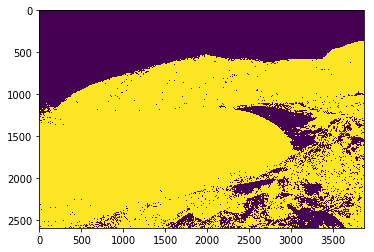

In [110]:
plt.imshow(img_binary)

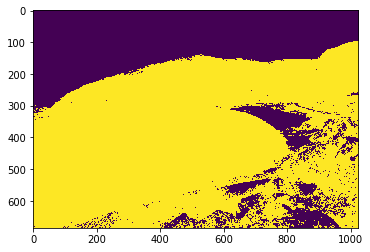

In [111]:
plt.imshow(img2_binary)

In [112]:
Out[107]**2

0.069940577829383246

In [107]:
1024/np.max(img.shape)

0.26446280991735538

In [ ]:
l = skimage.measure.perimeter(img_binary)
    area = img_binary.sum()

In [95]:
%%time
org = get_tile_features(3, 3, img, img_gray, img_binary)

CPU times: user 15.5 s, sys: 216 ms, total: 15.7 s
Wall time: 15.7 s


In [96]:
%%time
small = get_tile_features(3, 3, img2, img2_gray, img2_binary)

CPU times: user 1.89 s, sys: 160 ms, total: 2.05 s
Wall time: 2.06 s


In [79]:
np.array(org)-np.array(small)

array([  2.84158281e-03,   5.40832774e-03,   6.74004865e-03,
         4.89992021e-05,   1.35740563e-02,  -2.23009775e-02,
        -1.97152761e-03,   1.14532318e-02,  -1.99309068e-02,
         4.96743236e-04,   1.23676295e-02,  -2.73996822e-02,
         7.03990450e-05,   2.55697027e-04,   4.22333031e-04,
         5.26492168e-04,   1.29258513e+02,   1.10846336e+03,
         8.57062861e+02,   2.18777501e+00,   8.70882524e+00,
         2.50402808e+01,   3.83836342e-03,   2.44782002e-02,
         1.48670882e-01,   1.72181216e-01,   1.92997536e+03,
         5.38305047e+02,   3.06119728e+03,   1.64125071e-03,
         6.61167269e-04,  -3.34041820e-02])

In [83]:
import pandas as pd

In [97]:
pd.DataFrame({"small":small, "org":org})

,org,small
0,0.347657,0.344816
1,0.263355,0.257947
2,0.236866,0.230126
3,0.657783,0.657734
4,0.126117,0.112543
5,-0.129902,-0.107601
6,0.642477,0.644449
7,0.197986,0.186532
8,-0.211720,-0.191789
9,0.590778,0.590281


In [3]:
img = img_as_float(imread(target))

In [4]:
img.shape

(386, 687, 3)

In [7]:
tile_h = int(img.shape[0]/5)
tile_w = int(img.shape[1]/5)

In [37]:
img_gray = color.rgb2gray(img)
img_binary = gray2binary(img_gray)

In [40]:
tile_row = 4
tile_col = 0

In [63]:
features = img2features(img)

In [64]:
len(features)

800

In [103]:
features = tile2features(tile, tile_gray, tile_binary)

In [105]:
len(features)

32

In [93]:
kernel2feature(tile, weights)

0.00070527536908725728

In [80]:
DOOG2_weight(2).shape, DOOG2_weight(4).shape, DOOG2_weight(8).shape

((17, 17), (33, 33), (65, 65))

In [95]:
tile2doog_features(tile)

[0.13765982813667971,
 0.49999554479585528,
 0.82583922136457,
 1.0295142695869703]

In [87]:
[kernel2feature(tile, DOOG2_weight(i)) for i in [1, 2, 4, 8, 16]]

[0.00013765982813667972,
 0.00049999554479585528,
 0.00082583922136456999,
 0.0010295142695869704,
 0.0011416206025065398]

In [21]:
# maybe too small?

In [22]:
# sum might be better.

np.sum([np.sum(convolve(tile[:, :, i], weights)) for i in range(3)])

22.31984960550443

In [68]:
np.max(DOOG2_weight(1))

0.041748393641227621

In [69]:
np.max(DOOG2_weight(3))

0.0046387104045808461

In [70]:
np.max(DOOG2_weight(7))

0.00085200803349444118

In [72]:
np.max(DOOG2_weight(7)/  np.linalg.norm(DOOG2_weight(7)))

0.052987915559242309

In [71]:
# https://github.com/pdollar/toolbox/blob/master/filters/FbMake.m
# 0.5, 1, 1.5, 2.0

In [82]:
[np.max(convolve(tile[:, :, i], weights)) for i in range(3)]

[0.071272975969383937, 0.022219196106824542, 0.036144642500056459]

In [83]:
[np.mean(convolve(tile[:, :, i], weights)) for i in range(3)]

[0.00043807751520494033, 0.00071622558181795083, 0.00096152301023888064]

In [84]:
[np.mean(convolve(tile[:, :, i], weights))*1000 for i in range(3)]

[0.43807751520494032, 0.71622558181795082, 0.96152301023888065]

In [63]:
np.max(weights)

0.041748393641227621

In [66]:
# np.max(weights / np.linalg.norm(weights))

0.36606071769805038

In [1]:
target = "data/bay/0001.jpeg"

In [3]:
img = img_as_float(imread(target))

In [4]:
img.shape

(386, 687, 3)

In [7]:
tile_h = int(img.shape[0]/5)
tile_w = int(img.shape[1]/5)

In [6]:
tile_h, tile_w

(77, 137)

In [7]:
tile = img[0:tile_h, 0:tile_w, :]

In [8]:
tile.shape

(77, 137, 3)

In [57]:
len(get_tile_features(4, 0, img, img_gray, img_binary))

32

In [69]:
calc_moment_of_inertia(tile_gray)

(0.45085867714422823, 0.26886279616649378)

In [70]:
shape_features(tile_gray, tile_binary)

[98.156225304209556,
 0.45085867714422823,
 0.26886279616649378,
 0.44021164021164022]

In [63]:
tile2 = img[4*tile_h:(5*tile_h), 0:tile_w, :]
tile2_gray = color.rgb2gray(tile2)
tile2_binary = gray2binary(tile2_gray)

In [71]:
shape_features(tile2_gray, tile2_binary)

[249.52704456687493,
 2.5185166529820617,
 1.7470656368143624,
 0.86001926782273608]

In [45]:
tile_gray.shape

(77, 137)

In [34]:
# should apply to original image, but just apply to tile for trial purpose.
threds = threshold_otsu(tile_gray)
tile_binary = tile_gray <= threds

In [36]:
skimage.measure.perimeter(tile_binary)

571.5452018978109

In [37]:
area = tile_binary.sum()

In [38]:
area

3328

In [56]:
compactness(tile_binary)

(98.156225304209556, 3328)

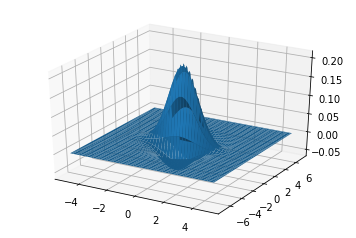

In [32]:
X,Y=np.meshgrid(np.linspace(-5,5,len(x)),np.linspace(-7,7, len(y)));
fig=plt.figure();
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(X, Y, f1)
# ax.plot_surface(X, Y, fx*fy, color='red')
# surf=ax.plot_surface(X,Y,G,c='red')
plt.show()

In [33]:
theta = 1/(4*math.pi)

In [35]:
inds = rotation_indices(1/(4*math.pi), f1.shape)

In [36]:
len(inds[0])

14000

In [37]:
f1r2 = f1[inds].reshape(f1.shape)

In [41]:
orientation_energy(tile_gray, (2*math.pi)/12)

51.861780304280764

In [42]:
orientation_energy(tile_gray, 0*(2*math.pi)/12)

2.0898866173974229

In [43]:
orientation_energy(tile_gray, 1*(2*math.pi)/12)

51.861780304280764

In [44]:
orientation_energy(tile_gray, 2*(2*math.pi)/12)

18.766855436860915

In [92]:
orientation_energy(tile_gray, 3*(2*math.pi)/12)

0.010338172986608721

In [93]:
[orientation_energy(tile_gray, i*(2*math.pi)/12) for i in range(12)]

[2.0898866173974229,
 51.861780304280764,
 18.766855436860915,
 0.010338172986608721,
 0.089705818498873713,
 0.41842571651551119,
 6.6475988898296573e-05,
 0.00061898107480311694,
 0.0041911733544362966,
 0.0046325663918409454,
 67.778711023843286,
 46.569291894587508]

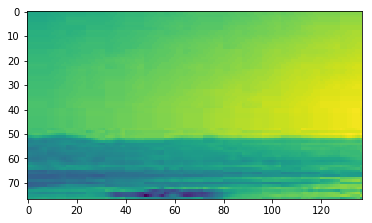

In [101]:
plt.imshow(tile_gray)

In [99]:
tile_gray.shape

(77, 137)

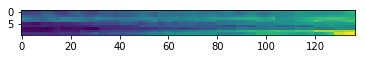

In [105]:
plt.imshow(tile_gray[60:70, :])

In [107]:
[orientation_energy(tile_gray[60:70, 0:60], i*(2*math.pi)/12) for i in range(12)]

[0.12653848807650903,
 1.779355973948693,
 0.59856313259303529,
 0.00035272497014036909,
 0.0025774499529571913,
 0.012898175596365091,
 2.2175847562225684e-06,
 2.1348975458477135e-05,
 0.00014528579077996317,
 0.00015551406705520887,
 2.3283209727642902,
 1.6392639280727841]

In [116]:
img.shape

(386, 687, 3)

In [117]:
tile_w

77

In [124]:
tile2 = img[4*tile_w:(5*tile_w), 0:tile_h, :]

In [125]:
tile2_gray = color.rgb2gray(tile2)

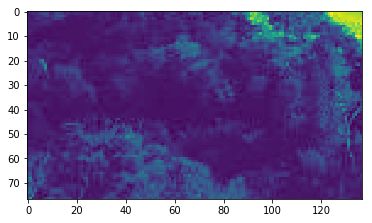

In [126]:
plt.imshow(tile2_gray)

In [129]:
[orientation_energy(tile2_gray, i*(2*math.pi)/12) for i in range(12)]

[4.869461932876205,
 7.1955365848890906,
 1.6050420156037013,
 0.014523668718819925,
 0.017492950842396486,
 0.024533722697677202,
 4.5751296488891631e-06,
 5.2186387453645893e-05,
 0.00034820923876056643,
 0.00035182277156667525,
 6.5269911924616899,
 7.2722472732760943]

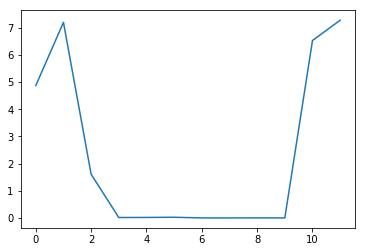

In [130]:
plt.plot(Out[129])

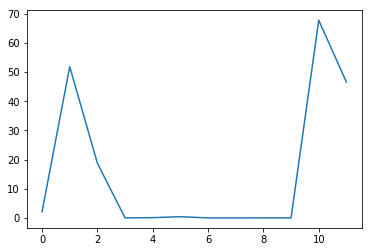

In [131]:
plt.plot(Out[93])

In [56]:
f1[0][4]

-5.0339499764591086e-11

In [50]:
f1[0][3]

-3.1620006979825382e-11

In [52]:
skimage.measure.moments(tile_gray, order=2)

array([[  6.04632279e+03,   2.20937014e+05,   1.08835769e+07],
       [  4.26940422e+05,   1.56406304e+07,   7.71974376e+08],
       [  3.96107262e+07,   1.45428178e+09,   7.19158387e+10]])

In [53]:
skimage.measure.moments(tile_gray, order=1)

array([[  6.04632279e+03,   2.20937014e+05],
       [  4.26940422e+05,   1.56406304e+07]])

In [54]:
skimage.measure.moments(tile_gray, order=0)

array([[ 6046.3227851]])

In [39]:
# cr, cc = ``M[1, 0] / M[0, 0]``, ``M[0, 1] / M[0, 0]`
M1 = skimage.measure.moments(tile_gray, order=1)
cr = M1[1, 0]/M1[0, 0]
cc = M1[0, 1]/M1[0, 0]

In [56]:
skimage.measure.moments_central(tile_gray, cr, cc, order=2)

array([[  6.04632279e+03,  -2.06003407e+05,   9.82909127e+06],
       [  2.06003407e+05,  -6.97879477e+06,   3.32715995e+08],
       [  1.64825002e+07,  -5.57613049e+08,   2.65970581e+10]])

In [40]:
mu2 = skimage.measure.moments_central(tile_gray, cr, cc, order=2)

In [41]:
moment_of_inertia = (mu2[2, 0]+mu2[0, 2])/mu2[0, 0]

In [42]:
moment_of_inertia

4351.6683430028861

In [71]:
convex_hull_image(tile_binary)

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ..., 
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], dtype=bool)

In [72]:
ratio3 = area/convex_hull_image(tile_binary).sum()

In [73]:
ratio3

0.44021164021164022

In [52]:
ratio_convex_hull(tile_binary, area)

0.44021164021164022

In [75]:
convex_hull_image(tile_binary).sum()

7560

### Check result

In [44]:
f1r = np.zeros_like(f1)

In [48]:
y_lim, x_lim = f1.shape

In [77]:
y_lim, x_lim = f1.shape

for x in range(x_lim):
    for y in range(y_lim):
        x1 = min(x_lim-1, max(0, int(x*math.cos(theta) - y*math.sin(theta))))
        y1 = min(y_lim-1, max(0, int(x*math.sin(theta) + y*math.cos(theta))))
        f1r[y][x] = f1[y1][x1]

In [93]:
inds[0][100*20+52],inds[1][100*20+52]

(24, 50)

In [94]:
f1r[20, 52]

-0.00096289672323596729

In [95]:
f1[24, 50]

-0.00096289672323596729

In [104]:
np.equal(f1r2, f1r).all()

True

In [101]:
f1r2[20, 52]

-0.00096289672323596729

In [14]:
gausres = G(1.5, 2, 2, np.arange(-5, 5), np.arange(-5, 5))

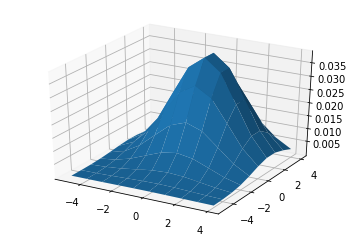

In [16]:

X,Y=np.meshgrid(np.linspace(-5,4,10),np.linspace(-5,4,10));
fig=plt.figure();
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(X, Y, gausres)
# surf=ax.plot_surface(X,Y,G,c='red')
plt.show()

In [18]:
DOOG2(np.arange(0, 5), np.arange(0, 5), 4, 2)

array([[ 0.00391391,  0.00388345,  0.00379349,  0.00364817,  0.00345402],
       [ 0.0036098 ,  0.00358171,  0.00349874,  0.0033647 ,  0.00318564],
       [ 0.00277449,  0.0027529 ,  0.00268913,  0.00258611,  0.00244848],
       [ 0.00161234,  0.0015998 ,  0.00156274,  0.00150287,  0.00142289],
       [ 0.00038658,  0.00038357,  0.00037468,  0.00036033,  0.00034115]])

In [20]:
DOOG2_weight(7.5)

array([[ -4.04866735e-06,  -4.29159896e-06,  -4.54013015e-06, ...,
         -4.54013015e-06,  -4.29159896e-06,  -4.04866735e-06],
       [ -5.93224151e-06,  -6.28819295e-06,  -6.65234908e-06, ...,
         -6.65234908e-06,  -6.28819295e-06,  -5.93224151e-06],
       [ -8.52716584e-06,  -9.03882017e-06,  -9.56226812e-06, ...,
         -9.56226812e-06,  -9.03882017e-06,  -8.52716584e-06],
       ..., 
       [ -8.52716584e-06,  -9.03882017e-06,  -9.56226812e-06, ...,
         -9.56226812e-06,  -9.03882017e-06,  -8.52716584e-06],
       [ -5.93224151e-06,  -6.28819295e-06,  -6.65234908e-06, ...,
         -6.65234908e-06,  -6.28819295e-06,  -5.93224151e-06],
       [ -4.04866735e-06,  -4.29159896e-06,  -4.54013015e-06, ...,
         -4.54013015e-06,  -4.29159896e-06,  -4.04866735e-06]])

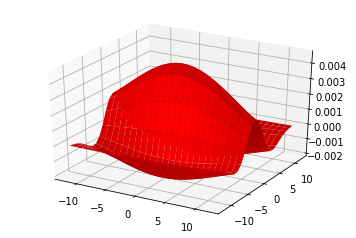

In [24]:
X,Y=np.meshgrid(np.linspace(-12,12,25),np.linspace(-12,12, 25));
fig=plt.figure();
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(X, Y, weights, color='red')
# surf=ax.plot_surface(X,Y,G,c='red')
plt.show()

In [25]:
np.mean([np.mean(convolve(tile[:, :, i], weights)) for i in range(3)])

0.00070527536908725728

In [30]:
dog = DOG(np.arange(-5, 5, 0.1))

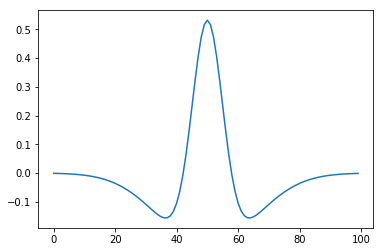

In [31]:
plt.plot(dog)

In [65]:
int(4 * 1.5 + 0.5)

6

In [66]:
x = np.arange(-6, 6+1)
y = np.arange(-6, 6+1)

In [67]:
f1, f2 = calc_f1f2(x, y)

In [68]:
inds = rotation_indices((2*math.pi)/12, f1.shape)

In [69]:
f1r = f1[inds].reshape(f1.shape)

In [113]:
np.arange(5).reshape(5, 1)*np.arange(5,10).reshape(1, 5)

array([[ 0,  0,  0,  0,  0],
       [ 5,  6,  7,  8,  9],
       [10, 12, 14, 16, 18],
       [15, 18, 21, 24, 27],
       [20, 24, 28, 32, 36]])

In [122]:
np.arange(5).reshape(1, 5)*np.arange(5,10).reshape(5, 1)

array([[ 0,  5, 10, 15, 20],
       [ 0,  6, 12, 18, 24],
       [ 0,  7, 14, 21, 28],
       [ 0,  8, 16, 24, 32],
       [ 0,  9, 18, 27, 36]])

In [126]:
(np.arange(5).reshape(1, 5)*np.arange(5,10).reshape(5, 1))[1][3]

18

In [127]:
np.arange(3).reshape(1, 3)*np.arange(5,10).reshape(5, 1)

array([[ 0,  5, 10],
       [ 0,  6, 12],
       [ 0,  7, 14],
       [ 0,  8, 16],
       [ 0,  9, 18]])

In [112]:
np.arange(5).reshape(1, 5)[0]

array([0, 1, 2, 3, 4])

In [ ]:
tmp = norm.pdf(np.arange(-10, 10, 0.1), scale=5)
plt.plot(np.arange(-10, 10, 0.1), tmp)

In [11]:
calc_moments(tile[:, :, 0])

(0.37209400017472155, 0.10217063437619424, -0.09780083132038393)

In [21]:
color.rgb2gray(tile[0:3, 0:3, :])

array([[ 0.51498902,  0.51498902,  0.51498902],
       [ 0.51498902,  0.51498902,  0.51498902],
       [ 0.51777176,  0.51777176,  0.51777176]])

In [26]:
tmp = tile[0:3, 0:3, :]

In [27]:
[calc_moments(tmp[:, :, i]) for i in range(3)]

[(0.25882352941176467, 0.0055459355387180269, 0.15959603823333823),
 (0.56470588235294117, 0.0, -0.241661910774848),
 (0.78954248366013069, 0.0018486451795726665, -0.44268744485027073)]

In [28]:
len(calc_4_moments(tmp))

12

In [29]:
calc_4_moments(tile)

[0.37209400017472155,
 0.10217063437619424,
 -0.09780083132038393,
 0.60834722741120328,
 0.069683966722592888,
 -0.2781541238099151,
 0.8166978005535328,
 0.05321479042159858,
 -0.4683674599313368,
 0.5731654929470128,
 0.073980597551597832,
 -0.2485871934295749]

In [19]:
def gray_arr(rgbarr):
    return (rgbarr[:, :, 0]+rgbarr[:, :, 1]+rgbarr[:, :, 2])/3

In [20]:
gray_arr(tile[0:3, 0:3, :])

array([[ 0.53594771,  0.53594771,  0.53594771],
       [ 0.53594771,  0.53594771,  0.53594771],
       [ 0.54117647,  0.54117647,  0.54117647]])

In [21]:
tile[0:3, 0:3, 0]

Image([[65, 65, 65],
       [65, 65, 65],
       [68, 68, 68]])

In [22]:
tile[0:3, 0:3, 1]

Image([[144, 144, 144],
       [144, 144, 144],
       [144, 144, 144]])

In [23]:
tile[0:3, 0:3, 2]

Image([[201, 201, 201],
       [201, 201, 201],
       [202, 202, 202]])

In [24]:
(tile[0:3, 0:3, 0]+tile[0:3, 0:3, 1]+tile[0:3, 0:3, 2])/3

Image([[ 136.66666667,  136.66666667,  136.66666667],
       [ 136.66666667,  136.66666667,  136.66666667],
       [ 138.        ,  138.        ,  138.        ]])

In [9]:
r_1_moment = np.mean(tile[:, :, 0])

In [10]:
r_1_moment

94.88397004455399

In [11]:
np.sum(tile[:, :, 0])/(tile.shape[0]*tile.shape[1])

94.88397004455399

In [12]:
import math

In [13]:
np.sum((tile[:, :, 0]-r_1_moment)**2)/(tile.shape[0]*tile.shape[1])

678.78547533742858

In [14]:
np.mean((tile[:, :, 0]-r_1_moment)**2)

678.78547533742858

In [15]:
r_2_moment = np.mean((tile[:, :, 0]-r_1_moment)**2)**(1/2)

In [16]:
r_2_moment

26.053511765929532

In [73]:
math.sqrt(np.mean((tile[:, :, 0]-r_1_moment)**2))

26.05351176592953

In [81]:
r_3_moment = (np.mean((tile[:, :, 0]-r_1_moment)**3))**(1./3)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


In [68]:
r_3_moment

nan

In [91]:
np.mean((tile[:, :, 0]-r_1_moment)**3).astype(float)

-15511.299389127838

In [85]:
type(np.mean((tile[:, :, 0]-r_1_moment)**3))

numpy.float64

In [82]:
r_3_moment = np.power(np.mean((tile[:, :, 0]-r_1_moment)**3), 1/3)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in power
  """Entry point for launching an IPython kernel.


In [88]:
r_3_moment = np.power(np.mean((tile[:, :, 0]-r_1_moment)**3).astype(float), 1/3)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in power
  """Entry point for launching an IPython kernel.


In [89]:
r_3_moment

nan

In [105]:
-15511.299389127838**(1/3)

-24.93921198669789

In [100]:
(-15511.299389127838)**(1/3)

(12.46960599334895+21.597991130845752j)

In [95]:
np.mean((tile[:, :, 0]-r_1_moment)**3).astype(float)

-15511.299389127838

In [97]:
(np.mean((tile[:, :, 0]-r_1_moment)**3).astype(float))**(1/3)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


nan

Negative cuberoot return complex answer (it also valid from the methematical point of view, but not what people want)

- https://stackoverflow.com/questions/1361740/cubic-root-of-the-negative-number-on-python
- https://stackoverflow.com/questions/45906383/python-exponent-operator-with-fractional-exponents

In [107]:
calc_moment3(tile[:, :, 0], r_1_moment)

-24.93921198669789

In [108]:
r_3_moment = moment3(tile[:, :, 0], r_1_moment)

In [109]:
r_1_moment, r_2_moment, r_3_moment

(94.88397004455399, 26.053511765929532, -24.93921198669789)

In [113]:
calc_moments(tile[:, :, 1])

(155.12854298985687, 17.769411514261186, -70.92930157152836)

In [114]:
calc_moments(tile[:, :, 2])

(208.25793914115081, 13.569771557507638, -119.4337022824908)

In [32]:
tmp = np.array([3, 4, 5])

In [33]:
tmp**2

array([ 9, 16, 25])

In [34]:
tmp**3

array([ 27,  64, 125])

In [39]:
itile = tile.astype(int)

In [43]:
tile[0:3, 0:3, 0]

Image([[65, 65, 65],
       [65, 65, 65],
       [68, 68, 68]], dtype=uint8)

In [40]:
itile[0:3, 0:3, 0]

Image([[65, 65, 65],
       [65, 65, 65],
       [68, 68, 68]])

In [41]:
itile[0:3, 0:3, 0]**2

Image([[4225, 4225, 4225],
       [4225, 4225, 4225],
       [4624, 4624, 4624]])

In [42]:
itile[0:3, 0:3, 0]**3

Image([[274625, 274625, 274625],
       [274625, 274625, 274625],
       [314432, 314432, 314432]])